In [103]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

from face_tally.ml_logic.image_prediction import predict_bounding_boxes, crop_image
from face_tally.params import *
from face_tally.ml_logic.model import get_model
from rembg import remove
import os


In [105]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
images_path = os.path.join(parent_path, 'images')


backgrounds = {
    "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
    "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
    "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
    "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
    "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
    "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
    "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
}

genres = {
    "warrior": Image.open(os.path.join(images_path, 'warrior.png')),
    "princess": Image.open(os.path.join(images_path, 'princess.png'))
}


In [106]:
def get_images():
    current_path = os.getcwd()
    parent_path = os.path.dirname(current_path)
    images_path = os.path.join(parent_path, 'images')


    backgrounds = {
        "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
        "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
        "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
        "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
        "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
        "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
        "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
    }

    pics = {
        "Man": Image.open(os.path.join(images_path, 'warrior.png')),
        "Women": Image.open(os.path.join(images_path, 'princess.png')),
        "heart": Image.open(os.path.join(images_path, 'heart.png'))
    }

    return backgrounds, pics


In [107]:
model, _ = await get_model(MODEL_SOURCE)


✅ Loaded weights from the comet ML


In [138]:
character = Image.open('trial_images/random_person_pic.jpg')
# output = remove(character)
character_array = np.array(character)


In [139]:
model.predict(character_array)



0: 320x640 1 0, 622.4ms
Speed: 59.7ms preprocess, 622.4ms inference, 14.1ms postprocess per image at shape (1, 3, 320, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0'}
 orig_img: array([[[248, 248, 250],
         [248, 248, 250],
         [248, 248, 250],
         ...,
         [219, 220, 222],
         [219, 220, 222],
         [219, 220, 222]],
 
        [[248, 248, 250],
         [248, 248, 250],
         [248, 248, 250],
         ...,
         [219, 220, 222],
         [219, 220, 222],
         [219, 220, 222]],
 
        [[248, 248, 250],
         [248, 248, 250],
         [248, 248, 250],
         ...,
         [219, 220, 222],
         [219, 220, 222],
         [219, 220, 222]],
 
        ...,
 
        [[235, 236, 238],
         [235, 236, 238],
         [235, 236, 238],
         ...,
         [206, 207, 209],
         [206, 207, 209],
         [206, 207, 209]],
 
        [[235, 236, 238],
         [235, 236, 238],
         [235, 236, 238],
         ...,
         [206, 207, 209],
        

In [140]:
bb = predict_bounding_boxes(character_array, model, "COMET")
face = crop_image(character_array, bb)


0: 320x640 1 0, 186.1ms
Speed: 11.6ms preprocess, 186.1ms inference, 3.4ms postprocess per image at shape (1, 3, 320, 640)
(400, 800, 3)


In [141]:
backgrounds, pics = get_images()


In [142]:
from deepface import DeepFace


In [143]:
results = DeepFace.analyze(face, actions=["emotion", "age", "gender"])


Action: gender: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it] 


In [144]:
person = remove(face)


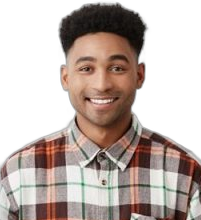

In [145]:
person = Image.fromarray(person)
person


In [146]:
background = backgrounds[results[0]["dominant_emotion"]]
energy = pics[results[0]["dominant_gender"]]
heart = pics["heart"]
age = results[0]['age']

background_resized = background.resize((600, 600))
heart_resized = heart.resize((50,50))

new_width = 320
original_width, original_height = person.size
new_height = int((new_width / original_width) * original_height)
person_resized = person.resize((new_width, new_height))

energy = energy.resize((120,120))

text_img = Image.new('RGBA', (600,600), (0, 0, 0, 0))
text_img.paste(background_resized, (0,0))
text_img.paste(energy, (30,70), mask=energy)
text_img.paste(person_resized, (190, 80), mask=person_resized)

text_img.paste(heart_resized, ((int(180 + (age / 100) * (450 - 180)), 470)), mask = heart_resized)

# Crear un objeto ImageDraw para dibujar en la imagen
draw = ImageDraw.Draw(text_img)
# Especificar la fuente y el tamaño del texto
font = ImageFont.load_default(55)
# Especificar la posición y el contenido del texto
text_position = (30, 450)
text_content = f"{age}"
# Dibujar el texto en la imagen
draw.text(text_position, text_content, font=font, fill=(0, 0, 0, 0))


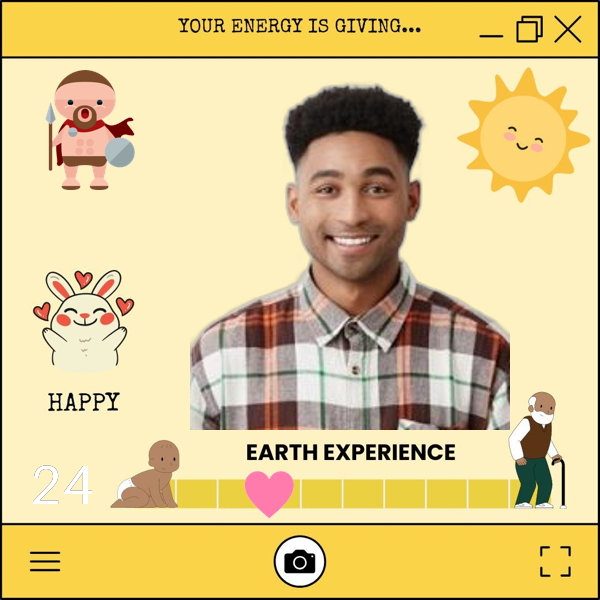

In [147]:
text_img
